# Assignment 2: Sensitivity Analysis with PRCCs via LHS
#### Moritz Kick, Maximilian Nowak

In [1]:
# Import modules from source
import os, sys
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as lin

from sinfo import sinfo
sinfo()

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
matplotlib  3.6.2
numpy       1.23.5
sinfo       0.3.4
-----
IPython             8.10.0
jupyter_client      7.4.9
jupyter_core        5.2.0
jupyterlab          3.5.3
notebook            6.5.4
-----
Python 3.11.0 (main, Mar  1 2023, 18:26:19) [GCC 11.2.0]
Linux-5.10.16.3-microsoft-standard-WSL2-x86_64-with-glibc2.31
8 logical CPU cores, x86_64
-----
Session information updated at 2023-06-13 21:48


# Implement the SEIR-Model from Assignment 1

In [2]:
from assignment1.seir import seirc_model, G1, G2

beta = 14/9  # infection rate
alpha = 7/3  # incubation rate
gamma = 7/9  # recovery rate
i0 = 1000  # initial number of infected individuals

# Define initial conditions
N = 80e6
S0 = N - i0
E0 = 0
I0 = i0
R0 = 0
C0 = I0
y0 = [S0, E0, I0, R0, C0]

### 1. Implement the LHS method for $n$-dimensional uniformly distributed random vectors.

In [3]:
from assignment2.lhs import latin_hypercube_uniform

pass

### 2. Verify your implementation.

(20, 2)


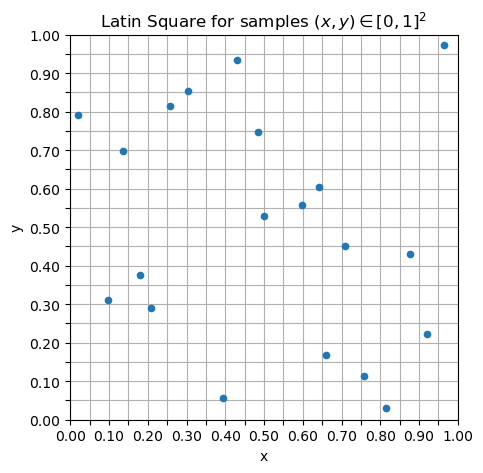

In [4]:
# set random seed for reproducability
# WARNING! Comment this line for production use
np.random.seed(42)

# generate latin hypercube samples and visualize result
dim = 2
n_samples = 20
samples = latin_hypercube_uniform(dim, n_samples)
print(samples.shape)


fig = plt.figure(figsize=(5,5))
ax = fig.gca()
ax.set_title(r"Latin Square for samples $(x,y) \in [0, 1]^2$")
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_xticks(np.arange(0, 1.01, 0.05))
ax.set_yticks(np.arange(0, 1.01, 0.05))
ax.set_xticklabels([x if not i%2 else "" for i, x in enumerate(ax.get_xticklabels())])
ax.set_yticklabels([y if not i%2 else "" for i, y in enumerate(ax.get_yticklabels())])
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.rc('grid', linestyle="-", color='lightgrey')
plt.grid()

plt.plot(samples[:, 0], samples[:, 1], ".", markersize="9")
plt.show()

In [5]:
# as proof check for duplicate values
u_col, c_col = np.unique(samples[:, 0], return_counts=True)
print(u_col[c_col > 1])

u_row, c_row = np.unique(samples[:, 1], return_counts=True)
print(u_row[c_row > 1])

[]
[]


### 3. Implement the computation of PCCs (not $\mathrm{P} R \mathrm{CCs}$ )

In [6]:
from assignment2.prcc import partial_corrcoef, prcc

pass

### 4. Verify the implementation of PCC and PRCC

In [7]:
import pandas as pd
pd.set_option('display.expand_frame_repr', False)

# Generate Latin hypercube samples
n_samples = 1000
dim = 2

# Generate random samples
X = latin_hypercube_uniform(dim, n_samples)

# Define the functions to be tested
funcs = {
    "Y = X1 + X2": lambda X: X[:, 0] + X[:, 1],
    "Y = X1 + X2^4": lambda X: X[:, 0] + X[:, 1]**4,
    "Y = X1 + cot(pi * X2)": lambda X: X[:, 0] + 1/np.tan(np.pi * X[:, 1])
}

# Test each function
df = pd.DataFrame(
    index=funcs.keys(),
    columns=['PCC', 'PRCC'],
    data=[[
            np.round(partial_corrcoef(X, f(X)), 3),
            np.round(prcc(X, f(X)), 3)
        ] for f in funcs.values()
    ],
)

print(df)

                                   PCC             PRCC
Y = X1 + X2                 [1.0, 1.0]   [0.976, 0.976]
Y = X1 + X2^4           [0.908, 0.866]   [0.915, 0.857]
Y = X1 + cot(pi * X2)  [0.019, -0.237]  [0.818, -0.994]


### 6. Construct the parameter domain $\mathcal{X}$.

In [8]:
beta_range = [1, 3]  # average number of contacts per week
alpha_range = [7/14, 7/2]  # mean latency rate per week
gamma_range = [7/14, 7/7]  # mean recovery rate per week
i0_range = [500, 2500]  # initial number of infected individuals

param_domain = np.array([beta_range, alpha_range, gamma_range, i0_range])
print(param_domain)

[[1.0e+00 3.0e+00]
 [5.0e-01 3.5e+00]
 [5.0e-01 1.0e+00]
 [5.0e+02 2.5e+03]]


### 7. Estimate the PRCCs between $Y_{\ell}=\mathcal{G}_{\ell}(\boldsymbol{X}), \ell=1,2$, and the input parameters $\boldsymbol{X} \sim \mathcal{U}(\mathcal{X})$ using $N=1,000$ LHS samples.

In [9]:
# LHS sampling
N_samples = 1000
lhs_samples = latin_hypercube_uniform(dim=4, n_samples=N_samples, low=param_domain[:, 0], high=param_domain[:, 1])

# Simulation time
T = 60
t = np.linspace(0, T, T+1)

# Store results
results_g1 = []
results_g2 = []

for beta, alpha, gamma, i0 in lhs_samples:
    S0 = N - i0
    y0 = [S0, E0, i0, R0, C0]  # update initial conditions with current sample of i0
    sol = seirc_model((beta, alpha, gamma, N)).solve(t, y0)
    results_g1.append(G1(sol[:, 4]))
    results_g2.append(G2(sol[:, 2], t))

results_g1 = np.array(results_g1)
results_g2 = np.array(results_g2)

# Compute PRCCs
prcc_g1 = prcc(lhs_samples, results_g1)
prcc_g2 = prcc(lhs_samples, results_g2)

### Display the PRCCs with a bar plot.

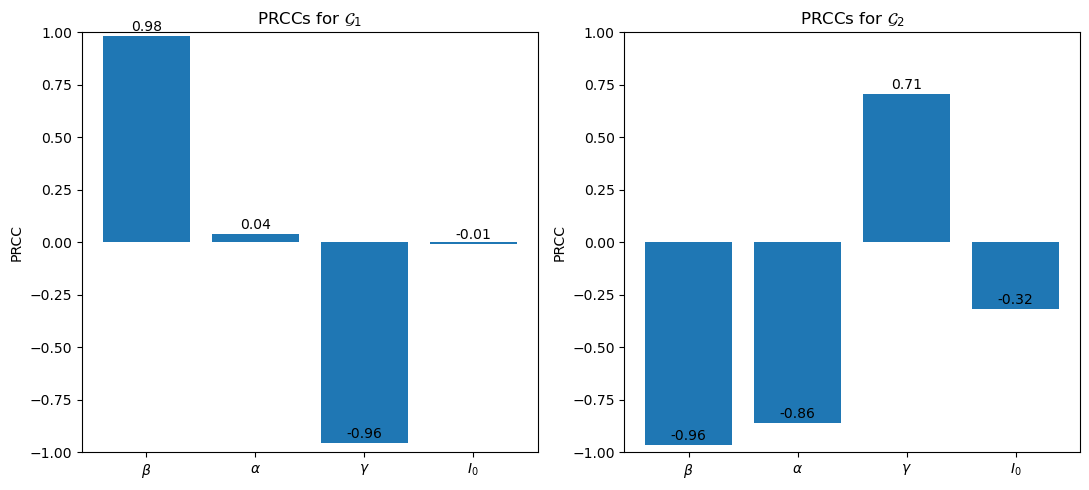

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))
labels = [r'$\beta$', r'$\alpha$', r'$\gamma$', r'$I_0$']

# PRCCs for G1
bars1 = ax1.bar(labels, prcc_g1)
ax1.set_ylim(-1, 1)
ax1.set_ylabel('PRCC')
ax1.set_title(r'PRCCs for $\mathcal{G}_1$')


# Adding the exact PRCC values on the bars for G1
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

# PRCCs for G2
bars2 = ax2.bar(labels, prcc_g2)
ax2.set_ylim(-1, 1)
ax2.set_ylabel('PRCC')
ax2.set_title(r'PRCCs for $\mathcal{G}_2$')


# Adding the exact PRCC values on the bars for G2
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

plt.tight_layout()
plt.show()